In [1]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64

In [2]:
num_classes=10
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

# Load a pretrained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")


# Freeze the layers of the backbone (neck)
for layer in base_model.layers:
    layer.trainable = False

# Add your task-specific head
head_model = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Adjust num_classes based on your task
])

# Combine the backbone and head
full_model = tf.keras.Sequential([
    base_model,
    head_model
])

# Compile the model
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [3]:
tf.keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

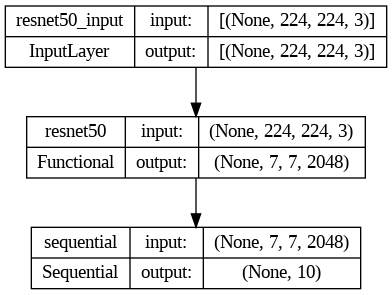

In [4]:
tf.keras.utils.plot_model(full_model, show_shapes=True, show_layer_names=True)

In [5]:
len(base_model.layers)

175

In [6]:
!ls

10_food_classes_10_percent  10_food_classes_10_percent.zip  __MACOSX  model.png  sample_data


In [7]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-12-11 18:54:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.207, 74.125.203.207, 64.233.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  31.0MB/s    in 6.2s    

2023-12-11 18:54:32 (26.0 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [8]:
!ls

10_food_classes_10_percent	10_food_classes_10_percent.zip.1  model.png
10_food_classes_10_percent.zip	__MACOSX			  sample_data


In [9]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [10]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("10_food_classes_10_percent/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator_app = ImageDataGenerator()
test_generator_app = ImageDataGenerator()

train_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_data_app = train_generator_app.flow_from_directory(train_dir,batch_size=32,target_size=(224,224), class_mode='categorical',seed=42)

test_data_app = test_generator_app.flow_from_directory(test_dir,batch_size=32,target_size=(224,224), class_mode='categorical',seed=42)

train_data = train_generator.flow_from_directory(train_dir,batch_size=32,target_size=(224,224), class_mode='categorical',seed=42)

test_data = test_generator.flow_from_directory(test_dir,batch_size=32,target_size=(224,224), class_mode='categorical',seed=42)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [12]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [13]:
import tensorflow as tf
import keras
from keras import layers
from keras.applications import EfficientNetB0
from keras.applications.resnet50 import ResNet50
def build_model(modeltype='Resnet50',no_of_classes=10):
  if 'Resnet50':
    feature_extractor_layer = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
  else:
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    feature_extractor_layer = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))

  model = tf.keras.Sequential([
      feature_extractor_layer,
      #tf.keras.layers.Dense(10, 'softmax')
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(num_classes, activation='softmax')  # Adjust num_classes based on your task
    ])

  model.trainable = False

  return model

In [14]:
model_resnet_full = build_model('Resnet50')
model_resnet_full.compile(loss='categorical_crossentropy',  optimizer='adam',metrics=['accuracy'])

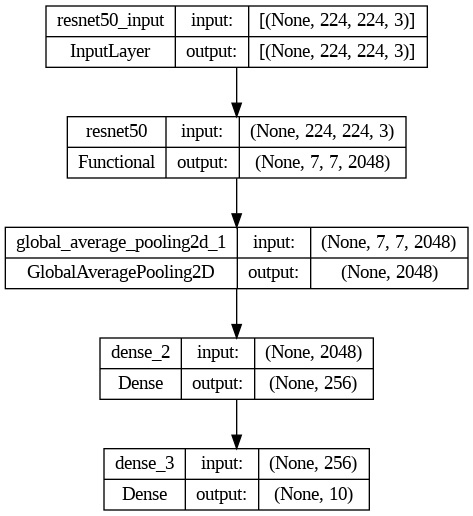

In [15]:
tf.keras.utils.plot_model(model_resnet_full, show_shapes=True, show_layer_names=True)

In [16]:
history_resnet_full = model_resnet_full.fit(train_data_app,epochs=5, steps_per_epoch=len(train_data_app), validation_data=test_data_app,validation_steps=len(test_data_app))

Epoch 1/5
24/24 [==============================] - 22s 645ms/step - loss: 2.9956 - accuracy: 0.1213 - val_loss: 3.0619 - val_accuracy: 0.1088
Epoch 2/5
24/24 [==============================] - 13s 554ms/step - loss: 2.9956 - accuracy: 0.1213 - val_loss: 3.0619 - val_accuracy: 0.1088
Epoch 3/5
24/24 [==============================] - 12s 496ms/step - loss: 2.9956 - accuracy: 0.1213 - val_loss: 3.0619 - val_accuracy: 0.1088
Epoch 4/5
24/24 [==============================] - 13s 554ms/step - loss: 2.9956 - accuracy: 0.1213 - val_loss: 3.0619 - val_accuracy: 0.1088
Epoch 5/5
24/24 [==============================] - 13s 553ms/step - loss: 2.9956 - accuracy: 0.1213 - val_loss: 3.0619 - val_accuracy: 0.1088
